# Example: Using gcm-filters on gridded surface velocity observations 
In this tutorial we extract and filter gridded surface ocean velocity data. These data are provided by Copernicus Marine Environment and represent a collection of satellite altimeter observations of sea surface surface that are spatially grided and processed to estimate surface geostrophic velocities. These data are publically available on Pangeo (https://catalog.pangeo.io/browse/master/ocean/sea_surface_height/). Both taper and Gaussian filter kernels are used in subsequent spatial filtering. Data are packaged into appropriate formats/types as required by gcm-filters. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import gcm_filters
from intake import open_catalog

## Load gridded satellite data 
1) Pull from pangeo OR 2) Load in an xarray netcdf file. Necessary variables include: latitude, longitude, u_velocity (ugos), v_velocity (vgos)

In [ ]:
# 1) 
# pull data from pangeo 
# ugos, vgos from pangeo (on 0.25 degree grid)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
# file loaded below (aviso_ke_jan_6_2015.nc) is extracted from ds as 
# ds2 = ds.isel(time=8040)
# ds2.to_netcdf(path='aviso_ke_jan_6_2015.nc')
aviso = ds.isel(time=8040) # select one day's worth of output

In [2]:
# 2) 
# (if using pangeo do not run this cell)
# (if using your own file, update filename )
# -- single day of AVISO gridded surface velocites, sea level anomaly (on 0.25 degree grid), extracted from pangeo 
# filename = ('/Users/.../datafile.nc')
filename = ('/Users/jakesteinberg/Documents/CPT/spatial_filtering/aviso_ke_jan_6_2015.nc')
aviso = xr.open_dataset(filename)

In [3]:
aviso

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
    time       datetime64[ns] ...
Data variables:
    adt        (latitude, longitude) float64 ...
    err        (latitude, longitude) float64 ...
    sla        (latitude, longitude) float64 ...
    ugos       (latitude, longitude) float64 ...
    ugosa      (latitude, longitude) float64 ...
    vgos       (latitude, longitude) float64 ...
    vgosa      (latitude, longitude) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [4]:
# -- extract and (re)package into data-array with identical dimensions -- 
ke_og = 0.5*(aviso['ugos']**2 + aviso['vgos']**2)
du = xr.DataArray(
    data=aviso['ugos'].data,
    dims=["lat", "lon"],
    coords=dict(lon=(["lon"], aviso['longitude'].data), lat=(["lat"], aviso['latitude'].data),),
)
dv = xr.DataArray(
    data=aviso['vgos'].data,
    dims=["lat", "lon"],
    coords=dict(lon=(["lon"], aviso['longitude'].data), lat=(["lat"], aviso['latitude'].data),),
)
dKE = xr.DataArray(
    data=ke_og.data,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data), lat=(["lat"], aviso['latitude'].data),),
)

In [5]:
# -- compute cell area -- 
# -- for each lat/lon grid box gcm-filters needs area in same format as du,dv
dy0 = 1852*60*(aviso['latitude'][2] - aviso['latitude'][1])
dx0 = 1852*60*np.cos(np.deg2rad(aviso['latitude']))*(aviso['longitude'][2] - aviso['longitude'][1])
area = dy0.data*np.tile(dx0, (len(aviso['longitude']),1))
area = np.transpose(area)
dA = xr.DataArray(
    data=area,
    dims=["lat", "lon"],
    coords=dict(
    lon=(["lon"], aviso['longitude'].data), lat=(["lat"], aviso['latitude'].data),),
)

In [6]:
# -- wet mask -- 
# -- land = 1, water = 0 -- 
Nx = len(area[1, :])
Ny = len(area[:, 1])
landMask = 0*np.random.randint(0,2,(Nx,Ny))
field_array = np.array(ke_og)
landMask[np.isnan(np.transpose(field_array))] = 1
landMask[np.transpose(field_array == 0)] = 1
landMask = np.transpose(landMask)
wetMask = 1 - landMask
dWM = xr.DataArray(
    data=wetMask,
    dims=["lat", "lon"],
    coords=dict(lon=(["lon"], aviso['longitude'].data), lat=(["lat"], aviso['latitude'].data),),
)

In [7]:
# -- call gcm-filters and select desired grid type -- 
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [8]:
# -- choose a filtering scale -- 
filter_scale = 4
dx_min = 1
# -- initialze filter object for two filter types -- 
# GAUSSIAN 
filter_simple_fixed_factor_G = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': dA, 'wet_mask': dWM}
)
filter_simple_fixed_factor_G
# TAPER 
filter_simple_fixed_factor_T = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': dA, 'wet_mask': dWM}
)
filter_simple_fixed_factor_T

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [9]:
# -- filter velocities, filter KE, and define EKE (for both Gaussian and Taper kernels) -- 
u_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(du, dims=['lat', 'lon'])
v_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(dv, dims=['lat', 'lon'])
KE_uvfilt = 0.5*(u_filtered_simple_fixed_factor**2 + v_filtered_simple_fixed_factor**2)
KE_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(dKE, dims=['lat', 'lon'])

u_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(du, dims=['lat', 'lon'])
v_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(dv, dims=['lat', 'lon'])
KE_uvfilt_T = 0.5*(u_filtered_simple_fixed_factor_T**2 + v_filtered_simple_fixed_factor_T**2)
KE_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(dKE, dims=['lat', 'lon'])

eke_G = KE_filtered_simple_fixed_factor - KE_uvfilt
eke_T = KE_filtered_simple_fixed_factor_T - KE_uvfilt_T

/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


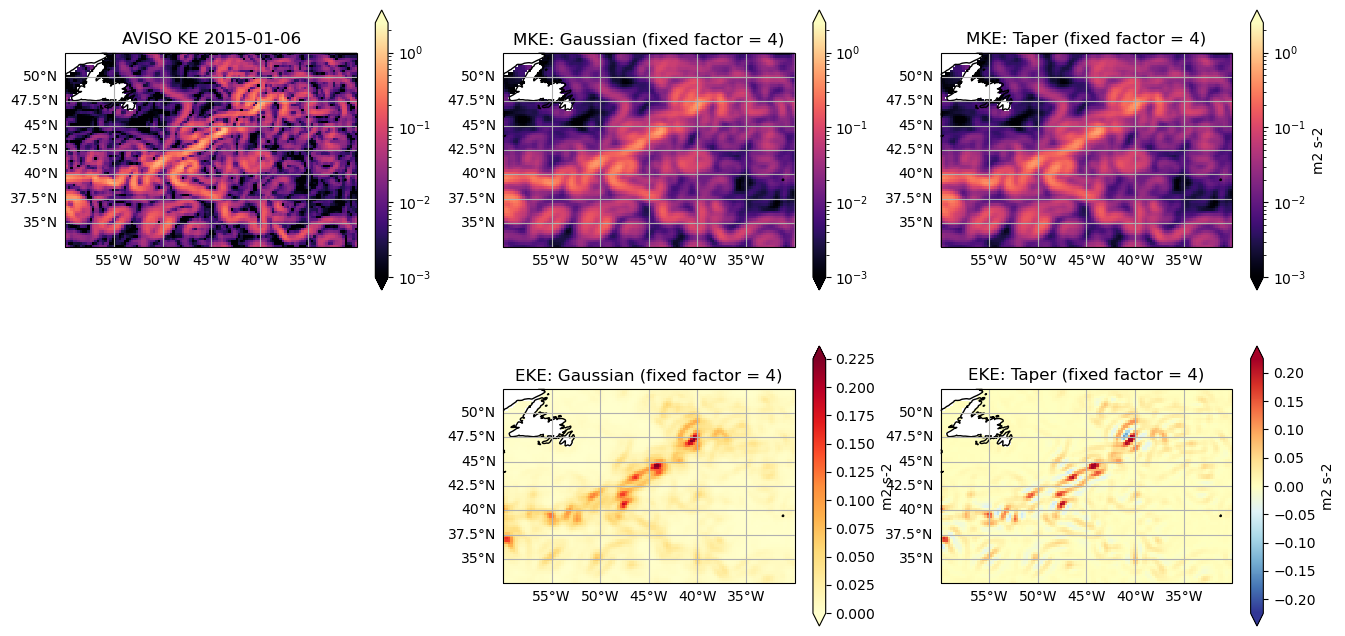

In [10]:
ke_lims = [0.001, 2.5]  # colormap limits (m^2 s^(-1))
ke_cmap = 'magma'       # colormap 

# -- PLOT --  
f,ax = plt.subplots(2,3,figsize=(16,8),subplot_kw={'projection':ccrs.PlateCarree()})
dKE.plot(ax=ax[0,0], cmap=ke_cmap, \
         norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,0].set(title='AVISO KE 2015-01-06')

KE_filtered_simple_fixed_factor.plot(ax=ax[0,1], cmap=ke_cmap, \
                                     norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,1].set(title='MKE: Gaussian (fixed factor = 4)')

KE_filtered_simple_fixed_factor.plot(ax=ax[0,2], cmap=ke_cmap, cbar_kwargs={'label': 'm2 s-2'}, \
                                     norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,2].set(title='MKE: Taper (fixed factor = 4)')

eke_G.plot(ax=ax[1,1], cmap='YlOrRd', cbar_kwargs={'label': 'm2 s-2'}, \
                                     vmin=0, vmax=0.225)
ax[1,1].set(title='EKE: Gaussian (fixed factor = 4)')

eke_T.plot(ax=ax[1,2], cmap='RdYlBu_r', cbar_kwargs={'label': 'm2 s-2'}, \
                                     vmin=-0.225, vmax=0.225)
ax[1,2].set(title='EKE: Taper (fixed factor = 4)')

gax = ax.flatten()
for i in [0,1,2,4,5]:
    gax[i].coastlines()
    gax[i].set_extent([300, 330, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
f.delaxes(ax[1,0])
plt.show()
# f.savefig('aviso_ke_mke_eke.jpg', dpi=500)